In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!pip install konlpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

In [ ]:
!dir

images					   LICENSE
install_mecab-ko_on_colab190912.sh	   README.md
install_mecab-ko_on_colab_light_210108.sh


In [2]:
total_data = pd.read_csv('/content/REVIEW.csv')
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 316352


In [3]:
total_data = total_data.drop('Test', axis=1)

In [4]:
total_data['label'] = np.select([total_data.Score > 3], [1], default=0)
total_data[:5]

,Review,Review Code,Score,Store Code (Review),Upload Date,User Id,label
0,가지마 이거봤으면 가지마,DB000001,1.0,STORE_DB00001,2021-07-27,16d9tp6,0
1,고기 올려놓고 손님한테 구우라고 하고 화장실감 공기밥 달라고 세번 얘기해야 가져다줌...,DB000002,1.0,STORE_DB00001,2021-07-25,unrrni,0
2,구워주는 고기집에 고기를 올려놓고 화장실 가고.. 손님한테 구우라는 건 뭔가요? 그...,DB000003,1.0,STORE_DB00001,2021-07-25,qr530u,0
3,"이동네서는 대형음식점 갈데가 별로 없으니, 배짱식으로 장사하는 곳. 음식 중상, ...",DB000004,2.0,STORE_DB00001,2021-07-17,vel3rk,0
4,손님말 안듣는 직원들이 근무하는곳이네..,DB000005,1.0,STORE_DB00001,2021-07-17,167lsjl,0


In [5]:
total_data['Score'].nunique(), total_data['Review'].nunique(), total_data['label'].nunique()

(5, 239626, 2)

In [6]:
#결측치 제거
total_data = total_data.dropna(axis=0)

In [7]:
# review 열에서 중복인 내용이 있다면 중복 제거
total_data.drop_duplicates(subset=['Review'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 178105


In [8]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 133578
테스트용 리뷰의 개수 : 44527


   label  count
0      0  52365
1      1  81213


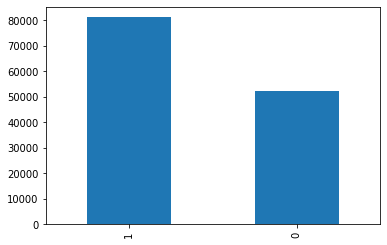

In [9]:
#자료가 불균형함
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [12]:
# 한글과 공백을 제외하고 모두 제거
train_data['Review'] = train_data['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['Review'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())
print('전처리 후 학습용 샘플의 개수 :',len(train_data))

Review                 0
Review Code            0
Score                  0
Store Code (Review)    0
Upload Date            0
User Id                0
label                  0
dtype: int64
전처리 후 학습용 샘플의 개수 : 133301


In [11]:
#테스트 데이터에도 동일한 과정
test_data.drop_duplicates(subset = ['Review'], inplace=True) # 중복 제거
test_data['Review'] = test_data['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['Review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 44425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [13]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [14]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [15]:
train_data['tokenized'] = train_data['Review'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
test_data['tokenized'] = test_data['Review'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [18]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 20874), ('먹', 19096), ('는데', 18639), ('안', 15945), ('있', 13825), ('음', 12610), ('없', 12262), ('었', 10743), ('네요', 9813), ('너무', 9452), ('만', 9447), ('어요', 9315), ('좋', 8884), ('맛있', 8831), ('어', 8385), ('시', 7995), ('않', 7967), ('면', 7921), ('했', 7761), ('습니다', 7232)]


In [19]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛있', 41520), ('먹', 28455), ('좋', 27238), ('어요', 26552), ('맛', 23539), ('었', 16693), ('있', 16591), ('는데', 15340), ('음', 13118), ('너무', 12315), ('습니다', 12127), ('친절', 12045), ('시', 10546), ('네요', 9400), ('어', 9024), ('면', 8962), ('지만', 8274), ('아요', 8273), ('았', 7462), ('주', 7248)]


긍정 리뷰의 평균 길이 : 18.711060948081265
부정 리뷰의 평균 길이 : 26.495060499310767


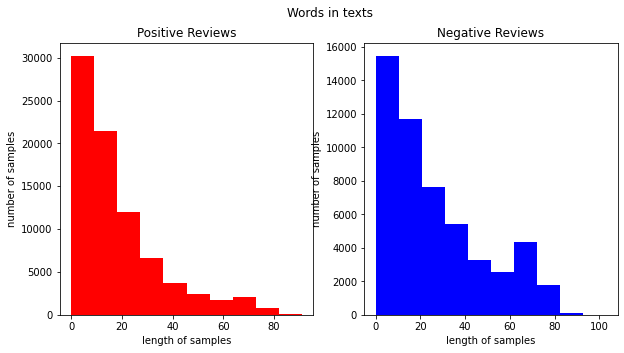

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40480
등장 빈도가 1번 이하인 희귀 단어의 수: 16056
단어 집합에서 희귀 단어의 비율: 39.66403162055336
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.553506870745321


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 24426


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])

[[170, 103, 77, 2803, 166, 4, 5], [151, 4, 359, 181], [6684, 4, 359, 744, 70, 44, 208, 20, 104, 131, 133, 52, 58, 25, 104]]


In [27]:
print(X_test[:3])

[[1, 196, 646, 251, 2, 340, 196, 1, 355, 3247, 1, 1900], [191, 1, 100, 506, 357, 66, 215, 86, 946, 3, 791, 57, 9, 13, 223, 4732, 18672, 1, 1, 3755, 679, 151, 4, 760], [61, 12, 5, 46, 22, 1304, 1, 84, 4, 72, 36]]


리뷰의 최대 길이 : 103
리뷰의 평균 길이 : 21.761104567857707


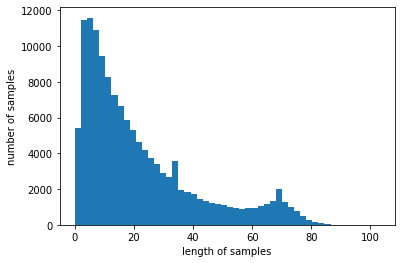

In [28]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [30]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.78319742537566


In [31]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [32]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1778/1778 [==============================] - 269s 150ms/step - loss: 0.3418 - acc: 0.8491 - val_loss: 0.3032 - val_acc: 0.8695

Epoch 00001: val_acc improved from -inf to 0.86951, saving model to best_model.h5
Epoch 2/15
1778/1778 [==============================] - 267s 150ms/step - loss: 0.2833 - acc: 0.8783 - val_loss: 0.2885 - val_acc: 0.8777

Epoch 00002: val_acc improved from 0.86951 to 0.87772, saving model to best_model.h5
Epoch 3/15
1778/1778 [==============================] - 270s 152ms/step - loss: 0.2613 - acc: 0.8903 - val_loss: 0.2796 - val_acc: 0.8812

Epoch 00003: val_acc improved from 0.87772 to 0.88125, saving model to best_model.h5
Epoch 4/15
1778/1778 [==============================] - 267s 150ms/step - loss: 0.2448 - acc: 0.8978 - val_loss: 0.2835 - val_acc: 0.8790

Epoch 00004: val_acc did not improve from 0.88125
Epoch 5/15
1778/1778 [==============================] - 267s 150ms/step - loss: 0.2300 - acc: 0.9057 - val_loss: 0.2833 - val_acc: 0.8782

Epo

### 리뷰 예측

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1389/1389 [==============================] - 32s 23ms/step - loss: 0.2843 - acc: 0.8801

 테스트 정확도: 0.8801


In [39]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [41]:
sentiment_predict('차슈가 너무 짜서 다 먹을 수가 없었음 남김 맛이 없어 남겼지만 보기에 양도 적고  오랜만에 가서 그런가 변한듯 마제소바는 진짜 매우 실망스러움 너무 짜서 먹을수가 없음.... 비주얼도 영 별로임   요즘같은 때에 이렇게 협소한 공간에서 먹을 이유가 없는 곳 제방문 의사 없음')

99.71% 확률로 부정 리뷰입니다.


In [69]:
# 별점 5점
score_5 = ['제 기준 라멘 최고 맛집. 이곳에서 라멘을 먹어보고 반해서 이리저리 라멘집을 전전해봤지만.. 이 곳만큼 제 입맛에 맛는 곳은 없었네요',
           '맛있어요 !  근데 그 매장이 좀 좁아서 불편하게 먹어야해요', '라멘도 라멘이지만 교자를 꼭 먹어야합니다.', '정자동 대표라멘집',
           '코이라멘은 어딜가든 똑같은 맛이에요 최고', '헐... 진짜 홍콩식 딤섬을 먹을 수 있다니 놀랐습니다. 홍콩서 10년 살다 온 사람으로서 맛도 인정합니다.진짜 하가우에 슈마이, 초이가우, 함수이콕 등등...모두 홍콩 딤섬 맞네요. 딱 하나, 홍콩 딤섬 식당은 뜨거운 차를 가져다 줍니다. 저는 한국사람이라 차가운 냉차가 좋지만 홍콩사람들은 너무 어색해 하네요. 뜨거운 차, 차가운 차 선택 가능하게 해주시면 좋을 것 같습니다.',
            '깔끔하고 맛있는 곳. 사리추가하면 양도 적당하고 재료 하나 하나 다 맛있게 먹었던곳','맛있어요 ~!! 늦게가면 소진된 메뉴가 많아요 !! 겨울에도 여름에도 맛있게 먹을 수 있는 모밀~~',
            '둘이 가서 탕수육도 먹고 싶어서 짬뽕이랑 탕수육 시켰더니 짬뽕 나눠서 주시더라구요! 센스 굳굳ㅎㅎ 탕수육 진짜진짜 맛있어요!! 튀김옷 얇고 돼지고기가 완전 꽉 차 있어서 식감도 엄청 좋습니다. 탕수육 강추!! 먹다가 찍어서 탕수육 양이 좀 적습니당',
           '코스요리로 먹었는데 대만족'
           ]
len(score_5)

10

In [70]:
# 별점 4점
score_4 = ['매우 협소하나 맛은 나쁘지않음', '뭐 동네 맛집.','정자 근처의 라멘집 중에서는 제일 괜찮은 것 같음.  초창기 계란이 달다고 피드백 했더니 바로 달걀이 적절하게 맛이 변해서 아주 좋았음. ',
           '차슈가 오향족발처럼 맛났어요. 한국인 맥시멀리스트에게 적합', '인생 최고의 딤섬 아직 여기 새우딤섬만한 딤섬 못 먹어봄', '적당히 맛있는 딤섬',
           '하가우. 시우마이. 샤오롱바오. 함소이꼬. 첸쩨우. 이빈란미엔. 흡 딤섬류는 다 넘나 맛있었는데 면은 별로였음, 남겼...ㅎ 전반적으로 간은 좀 짠편',
           '유린기는 너무너무너무 맛있어요 미친맛입니다 짬뽕은 재료상태는 좋았지만 자극적인 맛을 선호하는 저는 좀 싱거웠어요! 순하고 건강한 맛입니다 그치만 유린기는 최고였습니다',
           '육즙가득탕슉이랑 어향동고에 볶음밥 최고 맛있음!! 직원분들 엄청 친절하심~ 7시반에 가서 웨이팅 30-40분정도 하고 들어감!',
           '술먹고 난 뒤 혼자 해장하러가기 좋은곳 국밥맛집ㅋㅋ'
           ]
len(score_4)

10

In [71]:
# 별점 3점
score_3 = ['서현 판교등등 다른 체인점에서 너무 실망을 하고 본점은 다르겠지 하면서 정말 오랜만에 갔는데 그냥 맛이 달라졌네요…..국물에 물탄듯한 밍밍한맛  옛날에 첨 먹었던 그 깊은맛이 그립다ㅠ',
           '어느정도 진하고 괜찮긴한데 숙주랑 라멘이랑 안어울리고 그냥 그렇네요. 특출나게 맛있거나 하진 않네요. ',
           '변했으 바지버클 풀어가면서 탑처럼쌓인 지로라멘 완식하고가던 그런 추억이 무색하게도 챠슈도 퍽퍽해졌고 양도 애매해졌고 아부라도 .... 초심의 라멘으로 돌아와주세요',
           '초창기부터 갔었던 내 최애맛집 이었는데 지금은.. 공장화되면서 슬퍼짐ㅠㅠ','라멘맛 그러저럭 괜찮은데 가게가 너무 좁음', '옛날엔 진짜진짜 감동받을정도로 맛있었는데 지금은 그냥 괜찮은 라멘집정도. 혼라멘하기 좋음 시간대만 잘 고른다면',
           '전반적으로 새우가 많이 들었어요~ 한국에서 주로 안파는 메뉴 많고 독특하긴 한데 느끼해요 ㅠㅠ ', '웨이팅 없을 때 운 좋게 들어갔음 냉소바는 ㄱㅊ았는데 으레 그렇듯.. 마끼가 너무 돈아까웠다','감동적인 맛은 아닙니다 고급진 식재료인 성게알이 올라간다는 점 고등어 구이가 겉이 짭짤하고 속은 담백하다는 점 말고 국물이나 면이 특별히 맛있는지는 잘 모르겠습니다 온소바는 단맛이 덜하고 짰습니다 냉소바는 달달하고 아는 맛입니다 마끼는 김이 질기고 그닥 추천할정돈 아닙니다',
           '일반 중식당보다 조금 더 비싸고 조금 더 퀄리티 좋은 중식당. 가격대비 맛이 떨어지는 건 아니지만 월등히 좋은 것도 아님. 미리 예약만한다면 회식장소로는 아주 좋습니다.'
           ]
len(score_3)

10

In [83]:
# 별점 2점
score_2 = ['차슈가 너무 짜서 다 먹을 수가 없었음 남김 맛이 없어 남겼지만 보기에 양도 적고  오랜만에 가서 그런가 변한듯 마제소바는 진짜 매우 실망스러움 너무 짜서 먹을수가 없음.... 비주얼도 영 별로임   요즘같은 때에 이렇게 협소한 공간에서 먹을 이유가 없는 곳 제방문 의사 없음',
           '가맹점이 우후죽순으로 생기더니 ㅠ 가격도 맛도 변해간다.. 어느날 가격이 왕창 뛰더니(물가 상승으로 이해한다만….) 무엇보다 고기는 퍽퍽 육수는 밍밍 면은 왜이렇게 얇고 건조하죠ㅠ  돌아와요 코이.. 분당 맛집 중 하나였눈데……. p.s 고기는 사진만 봐도 건조해보임',
           '대만 홍콩에서 딤섬 다 먹어봤는데 이곳 딤섬은 분발해야할듯요. 임대료가 너무 비싸서 그런가요?', '오랜만에 찾아간 미미면가맛은있었습니다. 그러나 직원분(특히 여자분)친절하지않은기분이랄까?? 썩 기분좋은 식사는 아니네요!주문할때 말귀를 잘 못알아 들으시고 제가 메뉴품절됐는지 물어봤는데 가지튀김이요 이러면서 딴소리하시고...음..?? 혼자서 저의 주문을 창조하고 계셔서 뭔가싶었어여 그리고 소스 달라고 부탁해도 대꾸도 안하시고해서 제 말이 무시된건가 싶었어서 어리둥절 기분언짢 ㅋㅋ가격에비해 서비스가 너무 구려요 여러모로 실망했습니다',
           '솔직히 왜 유명하지, 뭐가 특별한지 모르겠는 느낌.. 냉소바 사실 일본 편의점가면 엄청 맛있거든요 만드는것도 어렵지않구요. 음식이 대체적으로 비싸고 직원들이 종종 불친절하고 웨이팅도 너무 김 ㅜㅜ ',
           '흠...? 인스타에서 너무 유명하길래 가봤는데 기대한만큼 맛있었는진 잘 모르겠어요! 우니도 조금 쿰쿰한 향이있었고 사람이 많다보니까 너무너무 바쁘셔서 응대부분에 조금 취약한 음식점인것같아요. 가격도 양에비해 비싸단 생각이 들었어요. 지인들한테 모밀/소바 미슐랭 맛집으로 저는 미진을 추천드릴것같네요.',
           '가격 대비 음식맛은 괜찮은 편이다. 특히 탕수육이 맛있다. 하지만 대체로 간이 세다(짠 편이다). 또한 매니저가 매우 불친절하고 가격이 비싼 요리를 주문하도록 유도한다.',
           '일단 너무 시끄럽습니다. 앞사람하고 이야기 불가능. 업소 책임은 아니겠지요. 게살볶음. 탕수육. 짬뽕 괜찮으나 시끄러운 분위기탓에 다시 방문할지는 의문. ',
           '최악임 차라리 배달시킬걸.....', '제 기준 가격, 맛 평가했을때 선호할 정도 안됨. 육회는 그냥 입 심심해서 주워먹었음'
           ]
len(score_2)

10

In [73]:
# 별점 1점
score_1 = ['2018 여름 미국 유학 가기전까지 맛있었는데, 체인점 하고 나서부터 맛이 없어졌다 길래 먹어봄. 진짜 무맛임ㅋㅋㅋ 매운거 먹었는데 그냥 곰탕에 고춧가루 푼 수준. 이제 다시는 안갈듯. ',
           '정말 좋아하는 라멘 덮밥집이었는데 이제 안가요 맛 양 둘다 너무 변했어요 맛집이 하나 사라져서 너무 마음이 아프네요',
           '먹을때는 맛있으나 식후에 부담이 조금 있음 매장이 좁아 식사 시간에 대기가 길다 식후에 양치중 이사이에 껴있던 뭔가가 나왔는데, 아마 식재료를 담던 포장조각이었던거 같다. 이거뿐이라면 다행이지만 아니라면 난 이미 음식이 아닌걸 먹은거겠지.  처음 먹었을때는 근처 마카나이보다는 나았다고 생각했는데, 찬찬히 생각해보니 그냥 가까운데서 빨리 먹어야겠다. ',
           '평일 저녁타임 직원분 실례지만 땀냄새가 너무 심합니다... 가게 들어서자마자 나길래 바닥에 걸레질 하신 냄새인줄 알았는데, 서빙하러 지나다니실 때마다 냄새 나는거 보고 충격먹었습니다.. 웬만하면 참는데 입맛이 떨어질 정도예요.. 환기라도 해주셨으면 좋겠습니다.',
           '가게 정말 좁은데 직원들이 쉴새없이 수다떨어요. 웃고 떠들고 난리나요. 손님들 말 소리보다 커요. 지들 노는데 내가 낀 줄 알았어요. 불과 이번 해 3월 후기에도 같은 의견이 있네요? 전 그보다 훨씬 전에 갔는데요. 맛은 있지만 분당만 해도 참 맛있는 라멘집 많죠? 변함이 없는 걸 한결같다 해야할지 개선 의지가 없다고 해야할지. ^^ ㅋㅋ',
           '맛은 그냥저냥, 가격을 생각하면 좀 아깝다. 홀 알바가 5명인데 일하는 건 한 두명이고 나머지는 놀고있다. 서빙하다 국물을 지갑에 흘렸는데 말도 없이 그냥 간다. 차라리 인건비를 줄여서 가격을 내리는 건 어떨까.',
           '불친절한 직원분들은 그렇다치고 위생은 어떨지요. 한번가보고 실망했습니다. 이런 밥풀?음식물 떨어져있는테이블에서 밥먹으려니 ㅜㅜ 조금불편했습니다.',
           '제 입맛에는 특별히 맛있지 않았어요. 근데 오픈시간 10분전에도 문 잠그고 있는데 문앞에는 재료 소진되었다는 안내글이 붙어있어 오해하기 딱 좋더라구요?',
           '최악의 서비스 일하기싫어하는직원들', '일단 식기가 더럽고 컵에서 물고기 냄새나요 ( 첫번째 사진 보시면 짜장면 그릇에 짬뽕 국물 기름 묻어있어요)  짜장면 싱겁고 짬뽕은 그냥그냥  탕수육 간은 괜찮지만 소스가 별로에요'
           ]
len(score_1)

10

In [77]:
def predict_by_score(scores):
    for score in scores:
        sentiment_predict(score)

In [78]:
print('###5점 리뷰 감성분석###')
predict_by_score(score_5)

###5점 리뷰 감성분석###
93.81% 확률로 긍정 리뷰입니다.
91.96% 확률로 긍정 리뷰입니다.
92.41% 확률로 긍정 리뷰입니다.
59.66% 확률로 긍정 리뷰입니다.
95.12% 확률로 긍정 리뷰입니다.
95.53% 확률로 긍정 리뷰입니다.
97.92% 확률로 긍정 리뷰입니다.
96.90% 확률로 긍정 리뷰입니다.
99.63% 확률로 긍정 리뷰입니다.
97.70% 확률로 긍정 리뷰입니다.


In [79]:
print('###4점 리뷰 감성분석###')
predict_by_score(score_4)

###4점 리뷰 감성분석###
80.13% 확률로 부정 리뷰입니다.
84.63% 확률로 긍정 리뷰입니다.
72.49% 확률로 긍정 리뷰입니다.
62.51% 확률로 긍정 리뷰입니다.
98.81% 확률로 긍정 리뷰입니다.
88.08% 확률로 긍정 리뷰입니다.
79.36% 확률로 부정 리뷰입니다.
99.54% 확률로 긍정 리뷰입니다.
99.21% 확률로 긍정 리뷰입니다.
98.22% 확률로 긍정 리뷰입니다.


In [80]:
print('###3점 리뷰 감성분석###')
predict_by_score(score_3)

###3점 리뷰 감성분석###
99.53% 확률로 부정 리뷰입니다.
89.97% 확률로 부정 리뷰입니다.
96.77% 확률로 부정 리뷰입니다.
95.68% 확률로 긍정 리뷰입니다.
81.12% 확률로 부정 리뷰입니다.
89.78% 확률로 긍정 리뷰입니다.
83.47% 확률로 부정 리뷰입니다.
92.31% 확률로 부정 리뷰입니다.
90.82% 확률로 부정 리뷰입니다.
57.15% 확률로 부정 리뷰입니다.


In [84]:
print('###2점 리뷰 감성분석###')
predict_by_score(score_2)

###2점 리뷰 감성분석###
99.71% 확률로 부정 리뷰입니다.
98.94% 확률로 부정 리뷰입니다.
69.74% 확률로 긍정 리뷰입니다.
99.82% 확률로 부정 리뷰입니다.
98.72% 확률로 부정 리뷰입니다.
78.53% 확률로 부정 리뷰입니다.
96.45% 확률로 부정 리뷰입니다.
99.35% 확률로 부정 리뷰입니다.
99.52% 확률로 부정 리뷰입니다.
88.74% 확률로 부정 리뷰입니다.


In [85]:
print('###1점 리뷰 감성분석###')
predict_by_score(score_2)

###1점 리뷰 감성분석###
99.71% 확률로 부정 리뷰입니다.
98.94% 확률로 부정 리뷰입니다.
69.74% 확률로 긍정 리뷰입니다.
99.82% 확률로 부정 리뷰입니다.
98.72% 확률로 부정 리뷰입니다.
78.53% 확률로 부정 리뷰입니다.
96.45% 확률로 부정 리뷰입니다.
99.35% 확률로 부정 리뷰입니다.
99.52% 확률로 부정 리뷰입니다.
88.74% 확률로 부정 리뷰입니다.
